In [2]:
!pip install torch torchvision segmentation-models-pytorch opencv-python pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
import torch
import segmentation_models_pytorch as smp
import os
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim


##Loading the data


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Tree_Species_Dataset', transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Number of classes: 30


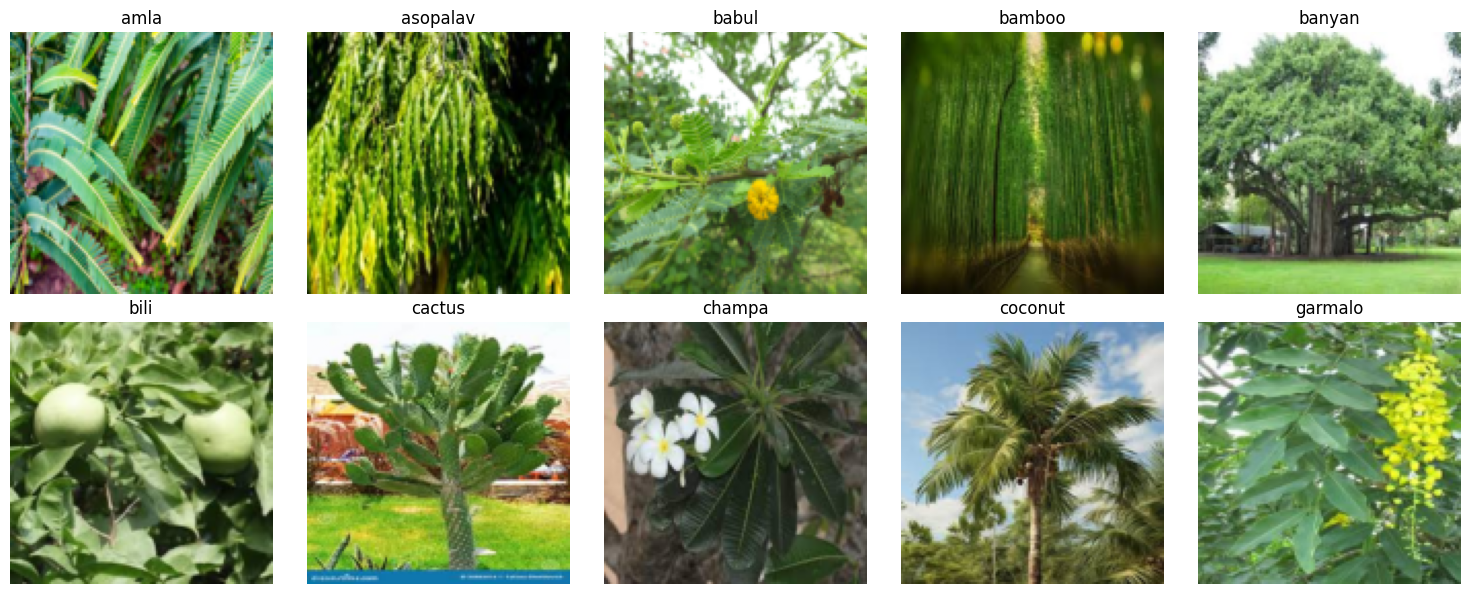

In [7]:


# Display number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# Display some sample images from different classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Get a few samples from different classes
samples_per_class = 10 # We'll pick a random image from the first 10 images of each class

for i in range(min(len(dataset.classes), len(axes))):
    class_name = dataset.classes[i]
    class_indices = [j for j, label in enumerate(dataset.targets) if label == i]
    if class_indices:
        # Pick a random image from the first few images of this class
        img_index = random.choice(class_indices[:samples_per_class])
        image, label = dataset[img_index]
        axes[i].imshow(image.permute(1, 2, 0)) # Permute dimensions for displaying
        axes[i].set_title(class_name)
        axes[i].axis('off')
    else:
        axes[i].set_title(f"No images for {class_name}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

##PRE TRAINED U NET ARCHITECTURE

In [8]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
Unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=30,
    activation=None,
).to(device)

Unet.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

## MAKING CNN

In [10]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN,self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
    )


    flattened_size = 512 * 8 * 8

    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flattened_size, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.Classifier(x)
    return x

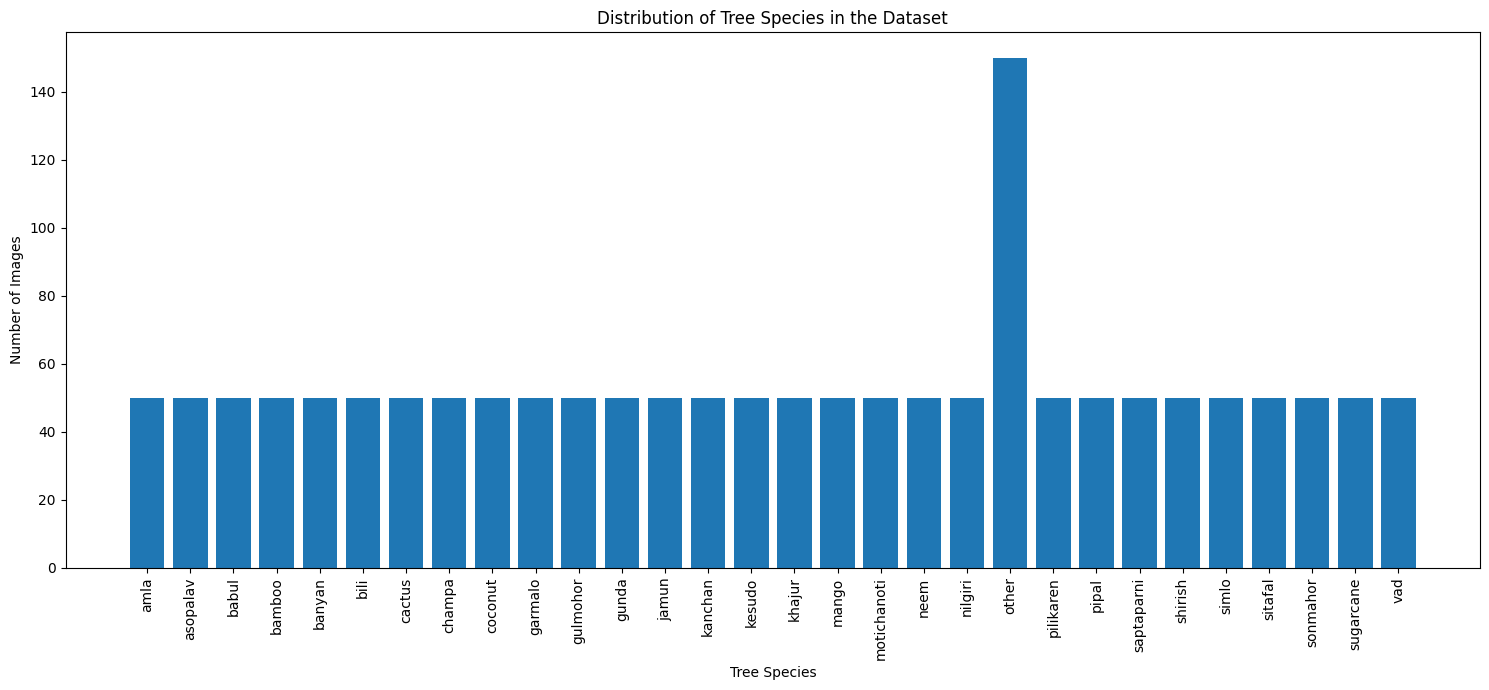

Class distribution displayed.


In [11]:
from collections import Counter

# Count the number of images in each class
class_counts = Counter(dataset.targets)

# Get class names and counts
class_names = [dataset.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(class_names, counts)
plt.xlabel("Tree Species")
plt.ylabel("Number of Images")
plt.title("Distribution of Tree Species in the Dataset")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Class distribution displayed.")

In [ ]:
model = CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 50  # You can adjust this if needed
for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct= 0
  total = 0

  for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item() * images.size(0) # Accumulate loss correctly
      _, predicted = outputs.max(1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = correct / total * 100
  print(f"Epoch {epoch+1}: Loss = {total_loss / total:.4f}, Accuracy = {accuracy:.2f}%") # Calculate average loss

# Save model
torch.save(model.state_dict(), "tree_classifier.pth")

print("\nCNN Model Training Finished.")

Epoch 1/50: 100%|██████████| 50/50 [08:03<00:00,  9.66s/it]


Epoch 1: Loss = 3.2474, Accuracy = 13.81%


Epoch 2/50: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it]


Epoch 2: Loss = 2.7551, Accuracy = 24.50%


Epoch 3/50: 100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


Epoch 3: Loss = 2.3382, Accuracy = 36.56%


Epoch 4/50: 100%|██████████| 50/50 [03:04<00:00,  3.69s/it]


Epoch 4: Loss = 1.8047, Accuracy = 54.44%


Epoch 5/50: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it]


Epoch 5: Loss = 1.2501, Accuracy = 72.19%


Epoch 6/50: 100%|██████████| 50/50 [03:04<00:00,  3.70s/it]


Epoch 6: Loss = 0.8325, Accuracy = 84.88%


Epoch 7/50: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it]


Epoch 7: Loss = 0.5168, Accuracy = 93.62%


Epoch 8/50: 100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


Epoch 8: Loss = 0.3414, Accuracy = 96.50%


Epoch 9/50: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it]


Epoch 9: Loss = 0.2391, Accuracy = 98.12%


Epoch 10/50: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it]


Epoch 10: Loss = 0.1791, Accuracy = 98.81%


Epoch 11/50: 100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


Epoch 11: Loss = 0.1288, Accuracy = 99.44%


Epoch 12/50: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it]


Epoch 12: Loss = 0.0963, Accuracy = 99.62%


Epoch 13/50: 100%|██████████| 50/50 [03:04<00:00,  3.70s/it]


Epoch 13: Loss = 0.0904, Accuracy = 99.62%


Epoch 14/50: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it]


Epoch 14: Loss = 0.0728, Accuracy = 99.69%


Epoch 15/50: 100%|██████████| 50/50 [03:07<00:00,  3.74s/it]


Epoch 15: Loss = 0.0596, Accuracy = 99.81%


Epoch 16/50: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


Epoch 16: Loss = 0.0496, Accuracy = 99.75%


Epoch 17/50: 100%|██████████| 50/50 [03:03<00:00,  3.67s/it]


Epoch 17: Loss = 0.0458, Accuracy = 99.81%


Epoch 18/50: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


Epoch 18: Loss = 0.0386, Accuracy = 99.88%


Epoch 19/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 19: Loss = 0.0468, Accuracy = 99.75%


Epoch 20/50: 100%|██████████| 50/50 [02:57<00:00,  3.56s/it]


Epoch 20: Loss = 0.0334, Accuracy = 100.00%


Epoch 21/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 21: Loss = 0.0258, Accuracy = 99.94%


Epoch 22/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 22: Loss = 0.0241, Accuracy = 99.94%


Epoch 23/50: 100%|██████████| 50/50 [02:59<00:00,  3.58s/it]


Epoch 23: Loss = 0.0268, Accuracy = 99.94%


Epoch 24/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 24: Loss = 0.0266, Accuracy = 99.81%


Epoch 25/50: 100%|██████████| 50/50 [03:09<00:00,  3.80s/it]


Epoch 25: Loss = 0.0246, Accuracy = 99.94%


Epoch 26/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 26: Loss = 0.0187, Accuracy = 100.00%


Epoch 27/50: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


Epoch 27: Loss = 0.0147, Accuracy = 99.94%


Epoch 28/50: 100%|██████████| 50/50 [02:57<00:00,  3.56s/it]


Epoch 28: Loss = 0.0164, Accuracy = 99.94%


Epoch 29/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it]


Epoch 29: Loss = 0.0128, Accuracy = 100.00%


Epoch 30/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 30: Loss = 0.0176, Accuracy = 99.94%


Epoch 31/50: 100%|██████████| 50/50 [02:57<00:00,  3.54s/it]


Epoch 31: Loss = 0.0163, Accuracy = 99.94%


Epoch 32/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it]


Epoch 32: Loss = 0.0155, Accuracy = 99.94%


Epoch 33/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it]


Epoch 33: Loss = 0.0111, Accuracy = 100.00%


Epoch 34/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it]


Epoch 34: Loss = 0.0100, Accuracy = 100.00%


Epoch 35/50: 100%|██████████| 50/50 [02:55<00:00,  3.50s/it]


Epoch 35: Loss = 0.0106, Accuracy = 100.00%


Epoch 36/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 36: Loss = 0.0119, Accuracy = 99.88%


Epoch 37/50: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


Epoch 37: Loss = 0.0098, Accuracy = 99.94%


Epoch 38/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 38: Loss = 0.0090, Accuracy = 100.00%


Epoch 39/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it]


Epoch 39: Loss = 0.0104, Accuracy = 99.94%


Epoch 40/50: 100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


Epoch 40: Loss = 0.0071, Accuracy = 99.94%


Epoch 41/50: 100%|██████████| 50/50 [02:58<00:00,  3.56s/it]


Epoch 41: Loss = 0.0072, Accuracy = 100.00%


Epoch 42/50: 100%|██████████| 50/50 [02:58<00:00,  3.56s/it]


Epoch 42: Loss = 0.0061, Accuracy = 100.00%


Epoch 43/50: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


Epoch 43: Loss = 0.0130, Accuracy = 99.81%


Epoch 44/50: 100%|██████████| 50/50 [02:55<00:00,  3.52s/it]


Epoch 44: Loss = 0.0143, Accuracy = 99.94%


Epoch 45/50: 100%|██████████| 50/50 [02:58<00:00,  3.58s/it]


Epoch 45: Loss = 0.0132, Accuracy = 99.88%


Epoch 46/50: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Epoch 46: Loss = 0.0083, Accuracy = 100.00%


Epoch 47/50: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it]


Epoch 47: Loss = 0.0070, Accuracy = 99.94%


Epoch 48/50: 100%|██████████| 50/50 [02:58<00:00,  3.56s/it]


Epoch 48: Loss = 0.0099, Accuracy = 99.94%


Epoch 49/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it]


Epoch 49: Loss = 0.0086, Accuracy = 99.94%


Epoch 50/50: 100%|██████████| 50/50 [02:54<00:00,  3.48s/it]

Epoch 50: Loss = 0.0103, Accuracy = 99.88%

CNN Model Training Finished.


In [12]:
def segment_and_classify(image_path, unet, classifier_model, class_names):
    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    resized = transforms.Resize((128, 128))(image)
    img_tensor = transforms.ToTensor()(resized).unsqueeze(0).to(device)

    # Segmentation
    with torch.no_grad():
        mask = unet(img_tensor)
        mask = torch.sigmoid(mask)
        mask = (mask > 0.5).float()

    # Apply mask
    mask_np = mask.squeeze().cpu().numpy()
    img_np = np.array(resized) / 255.0
    masked_img = img_np * mask_np[..., None]
    masked_img = np.clip(masked_img * 255, 0, 255).astype(np.uint8)
    masked_pil = Image.fromarray(masked_img)

    # Classification
    classifier_model.eval()
    input_tensor = transform(masked_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        output = classifier_model(input_tensor)
        _, pred = output.max(1)

    return class_names[pred.item()], masked_pil


In [13]:
from google.colab import files
files.download("tree_classifier.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = CNN(num_classes=30)
model.load_state_dict(torch.load('tree_classifier.pth'))
model.eval()

In [14]:
def classify_image(image_path, classifier_model, class_names):
    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    resized = transforms.Resize((128, 128))(image)
    img_tensor = transforms.ToTensor()(resized).unsqueeze(0).to(device)

    # Classification
    classifier_model.eval() # Set CNN to evaluation mode
    with torch.no_grad():
        output = classifier_model(img_tensor)
        _, pred = output.max(1)
        predicted_class_name = class_names[pred.item()]

    return predicted_class_name

In [44]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.10.1
    Uninstalling gradio_client-1.10.1:
      Successfully uninstalled gradio_client-1.10.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.31.0
    Uninstalling gradio-5.31.0:
      Successfully uninstalled gradio-5.31.0


In [ ]:
import gradio as gr
from PIL import Image
import torchvision.transforms as transforms
import torch


def classify_image_gradio(image: np.ndarray) -> str:

    image_pil = Image.fromarray(image.astype('uint8'), 'RGB')

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    img_tensor = transform(image_pil).unsqueeze(0).to(device)

    model.eval() 
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = output.max(1)
        predicted_class_name = class_names[pred.item()]

    return predicted_class_name

iface = gr.Interface(
    fn=classify_image_gradio,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Tree Species Classifier",
    description="Upload an image of a tree to get its predicted species."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e8c5dda9b3b7cd869e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2229, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1740, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e8c5dda9b3b7cd869e.gradio.live


##IMPORTED RESNET

In [31]:
class_names = dataset.classes  # List of actual class names
print(class_names)

['amla', 'asopalav', 'babul', 'bamboo', 'banyan', 'bili', 'cactus', 'champa', 'coconut', 'garmalo', 'gulmohor', 'gunda', 'jamun', 'kanchan', 'kesudo', 'khajur', 'mango', 'motichanoti', 'neem', 'nilgiri', 'other', 'pilikaren', 'pipal', 'saptaparni', 'shirish', 'simlo', 'sitafal', 'sonmahor', 'sugarcane', 'vad']


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os


# Paths
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CLASSES = 30
LR = 0.001
IMG_SIZE = 128



# Dataset
class_names = dataset.classes

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(weights="IMAGENET1K_V1")  # Pretrained weights
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # Replace final layer
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10  # You can adjust this if needed
for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct= 0
  total = 0

  for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item() * images.size(0) # Accumulate loss correctly
      _, predicted = outputs.max(1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = correct / total * 100
  print(f"Epoch {epoch+1}: Loss = {total_loss / total:.4f}, Accuracy = {accuracy:.2f}%") # Calculate average loss

# Save model
torch.save(model.state_dict(), "resnet.pth")

print("\nCNN Model Training Finished.")


Epoch 1/10: 100%|██████████| 50/50 [06:52<00:00,  8.25s/it]


Epoch 1: Loss = 2.5292, Accuracy = 34.75%


Epoch 2/10: 100%|██████████| 50/50 [02:44<00:00,  3.28s/it]


Epoch 2: Loss = 0.9653, Accuracy = 83.62%


Epoch 3/10: 100%|██████████| 50/50 [02:47<00:00,  3.34s/it]


Epoch 3: Loss = 0.3945, Accuracy = 96.06%


Epoch 4/10: 100%|██████████| 50/50 [02:45<00:00,  3.32s/it]


Epoch 4: Loss = 0.1397, Accuracy = 99.50%


Epoch 5/10: 100%|██████████| 50/50 [02:44<00:00,  3.28s/it]


Epoch 5: Loss = 0.0701, Accuracy = 99.88%


Epoch 6/10: 100%|██████████| 50/50 [02:44<00:00,  3.30s/it]


Epoch 6: Loss = 0.0436, Accuracy = 99.88%


Epoch 7/10: 100%|██████████| 50/50 [02:45<00:00,  3.32s/it]


Epoch 7: Loss = 0.0307, Accuracy = 99.94%


Epoch 8/10: 100%|██████████| 50/50 [02:45<00:00,  3.32s/it]


Epoch 8: Loss = 0.0228, Accuracy = 99.94%


Epoch 9/10: 100%|██████████| 50/50 [02:46<00:00,  3.34s/it]


Epoch 9: Loss = 0.0181, Accuracy = 99.94%


Epoch 10/10: 100%|██████████| 50/50 [02:45<00:00,  3.30s/it]

Epoch 10: Loss = 0.0137, Accuracy = 99.94%

CNN Model Training Finished.


In [32]:
model.load_state_dict(torch.load("resnet.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import gradio as gr
from PIL import Image
import torchvision.transforms as transforms
import torch


def classify_image_gradio(image: np.ndarray) -> str:

    image_pil = Image.fromarray(image.astype('uint8'), 'RGB')

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    img_tensor = transform(image_pil).unsqueeze(0).to(device)

    model.eval() 
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = output.max(1)
        predicted_class_name = class_names[pred.item()]

    return predicted_class_name

iface = gr.Interface(
    fn=classify_image_gradio,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Tree Species Classifier",
    description="Upload an image of a tree to get its predicted species."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f3f73cf5eda8e5f825.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
